# Lab 4.4: Introduction to Recurrent Neural Networks

## Duration: 45 minutes

## Learning Objectives
By the end of this lab, you will be able to:
- Understand why RNNs are perfect for sequence data
- Build your first RNN using TensorFlow/Keras
- Compare RNN performance with regular Dense networks on sequence tasks
- Use SimpleRNN, LSTM, and GRU layers
- Apply RNNs to text classification and time series problems

## Prerequisites
- **Labs 4.1, 4.2, & 4.3 completed** (TensorFlow basics, deep networks, CNNs)
- Understanding of neural networks
- Basic knowledge of sequences and time series

## Key Concepts
- **Sequences**: Data where order matters (text, time series, audio)
- **Memory**: How RNNs remember information from previous steps
- **LSTM**: Long Short-Term Memory for long sequences
- **GRU**: Gated Recurrent Unit (simpler than LSTM)
- **Text Processing**: Converting words to numbers

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("Lab 4.4: Introduction to Recurrent Neural Networks")
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")

print("\n🎯 What are sequences?")
print("  • Text: 'I love deep learning' → words have order!")
print("  • Time series: Stock prices over time")
print("  • Audio: Sound waves over time")
print("  • Video: Frames in temporal order")

print("\n❓ Why can't we use Dense or CNN layers?")
print("  • Dense: Treats all inputs independently")
print("  • CNN: Good for spatial patterns, not temporal")
print("  • We need memory to understand context!")

# Example of sequence importance
examples = [
    "The movie was not bad",  # Positive
    "The movie was bad",      # Negative
    "Not the best movie",     # Negative  
    "The best movie",         # Positive
]

print("\n📝 Sequence Examples (word order matters!):")
for i, example in enumerate(examples, 1):
    print(f"  {i}. '{example}'")
    
print("\n🧠 RNNs can understand context and sequence dependencies!")

Lab 4.4: Introduction to Recurrent Neural Networks
TensorFlow version: 2.20.0

🎯 What are sequences?
  • Text: 'I love deep learning' → words have order!
  • Time series: Stock prices over time
  • Audio: Sound waves over time
  • Video: Frames in temporal order

❓ Why can't we use Dense or CNN layers?
  • Dense: Treats all inputs independently
  • CNN: Good for spatial patterns, not temporal
  • We need memory to understand context!

📝 Sequence Examples (word order matters!):
  1. 'The movie was not bad'
  2. 'The movie was bad'
  3. 'Not the best movie'
  4. 'The best movie'

🧠 RNNs can understand context and sequence dependencies!


## Step 1: The Problem - Dense Networks Can't Handle Sequences

Let's first see why regular networks fail on sequential data:

Preparing Sequential Data for RNNs:
Loading IMDB movie reviews dataset...
Training samples: 25000
Test samples: 25000
Classes: 2 (0=negative, 1=positive)

Sample Reviews:
------------------------------

Review 1 (POSITIVE):
Length: 218 words
Text: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the sa...

Review 2 (NEGATIVE):
Length: 189 words
Text: ? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst...

Review 3 (NEGATIVE):
Length: 141 words
Text: ? this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touchi...


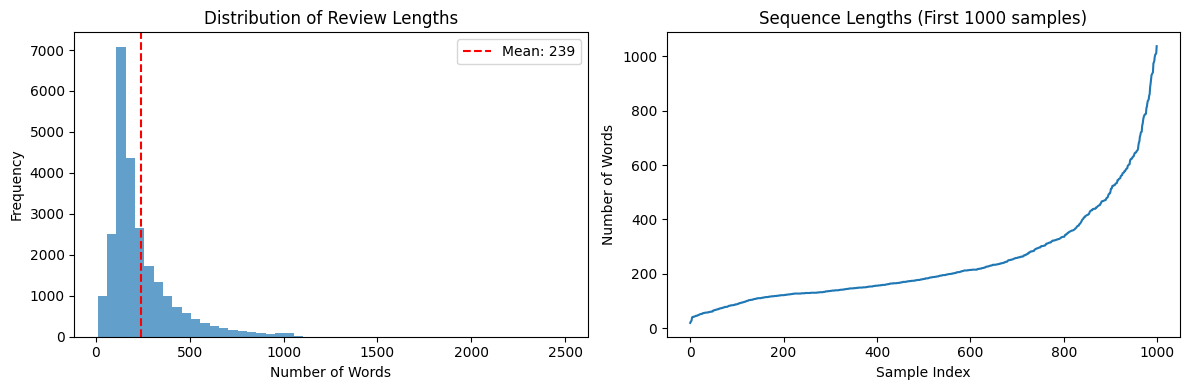


📊 Sequence Statistics:
  Shortest review: 11 words
  Longest review: 2494 words
  Average length: 238.7 words
  Standard deviation: 176.5 words

❗ Problems for Dense Networks:
  • Variable length inputs (can't handle different sizes)
  • Would need to pad/truncate all sequences
  • No understanding of word order
  • Can't capture long-range dependencies
  • 'movie great' vs 'great movie' treated identically

✅ This demonstrates why we need RNNs for sequential data!


In [28]:
print("Preparing Sequential Data for RNNs:")
print("=" * 50)

# Load IMDB movie review dataset for sentiment analysis
print("Loading IMDB movie reviews dataset...")
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=10000)

print(f"Training samples: {len(X_train_imdb)}")
print(f"Test samples: {len(X_test_imdb)}")
print(f"Classes: {len(set(y_train_imdb))} (0=negative, 1=positive)")

# Look at some sample reviews
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

print("\nSample Reviews:")
print("-" * 30)
for i in range(3):
    review_text = decode_review(X_train_imdb[i])
    sentiment = "POSITIVE" if y_train_imdb[i] == 1 else "NEGATIVE"
    print(f"\nReview {i+1} ({sentiment}):")
    print(f"Length: {len(X_train_imdb[i])} words")
    print(f"Text: {review_text[:200]}...")

# Show the sequence length problem
sequence_lengths = [len(x) for x in X_train_imdb]
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(sequence_lengths, bins=50, alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(np.mean(sequence_lengths), color='red', linestyle='--', 
           label=f'Mean: {np.mean(sequence_lengths):.0f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(sequence_lengths[:1000])), sorted(sequence_lengths[:1000]))
plt.title('Sequence Lengths (First 1000 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Number of Words')

plt.tight_layout()
plt.show()

print(f"\n📊 Sequence Statistics:")
print(f"  Shortest review: {min(sequence_lengths)} words")
print(f"  Longest review: {max(sequence_lengths)} words")
print(f"  Average length: {np.mean(sequence_lengths):.1f} words")
print(f"  Standard deviation: {np.std(sequence_lengths):.1f} words")

print("\n❗ Problems for Dense Networks:")
print("  • Variable length inputs (can't handle different sizes)")
print("  • Would need to pad/truncate all sequences")
print("  • No understanding of word order")
print("  • Can't capture long-range dependencies")
print("  • 'movie great' vs 'great movie' treated identically")

print("\n✅ This demonstrates why we need RNNs for sequential data!")

## Step 2: Data Preparation - Padding Sequences for RNN Input

RNNs need uniform input lengths. Let's prepare our data:

Preparing Sequential Data for RNNs:
Padding sequences to length 200...
Training data shape: (25000, 200)
Test data shape: (25000, 200)

Example of padded sequence:
Original length: 218
Padded length: 200
First 20 words: [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25]
Last 20 words: [ 134  476   26  480    5  144   30 5535   18   51   36   28  224   92
   25  104    4  226   65   16]
(Note: 0s are padding tokens)


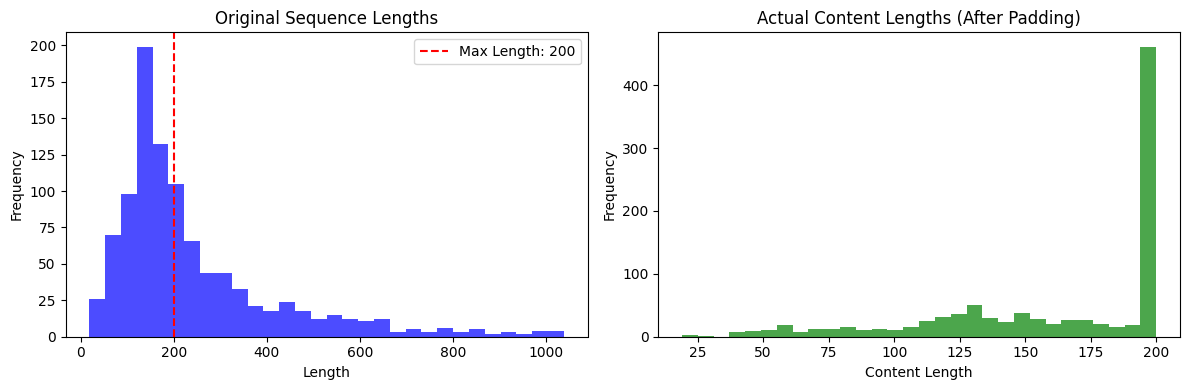


📊 Padding Impact:
  Samples truncated: 10677 (42.7%)
  Average padding ratio: 0.19 (19.5% padding)
  Efficiency: 80.5% of data is actual content

✅ Data Preparation Complete:
  • Sequences padded to uniform length
  • Truncated long sequences
  • Ready for RNN processing
  • Each word is represented by an integer ID


In [29]:
print("Preparing Sequential Data for RNNs:")
print("=" * 50)

# Pad sequences to make them the same length
max_length = 200  # Reasonable length that captures most reviews

print(f"Padding sequences to length {max_length}...")
X_train_padded = pad_sequences(X_train_imdb, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_imdb, maxlen=max_length, padding='post', truncating='post')

print(f"Training data shape: {X_train_padded.shape}")
print(f"Test data shape: {X_test_padded.shape}")

# Show what padding looks like
print("\nExample of padded sequence:")
sample_review = X_train_padded[0]
print(f"Original length: {len(X_train_imdb[0])}")
print(f"Padded length: {len(sample_review)}")
print(f"First 20 words: {sample_review[:20]}")
print(f"Last 20 words: {sample_review[-20:]}")
print("(Note: 0s are padding tokens)")

# Visualize the impact of padding
plt.figure(figsize=(12, 4))

# Before padding
plt.subplot(1, 2, 1)
original_lengths = [len(x) for x in X_train_imdb[:1000]]
plt.hist(original_lengths, bins=30, alpha=0.7, color='blue')
plt.title('Original Sequence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.axvline(max_length, color='red', linestyle='--', label=f'Max Length: {max_length}')
plt.legend()

# After padding
plt.subplot(1, 2, 2)
padded_lengths = [np.count_nonzero(x) for x in X_train_padded[:1000]]  # Count non-zero (non-padding)
plt.hist(padded_lengths, bins=30, alpha=0.7, color='green')
plt.title('Actual Content Lengths (After Padding)')
plt.xlabel('Content Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate padding statistics
actual_content_lengths = [np.count_nonzero(x) for x in X_train_padded]
truncated_samples = sum(1 for length in [len(x) for x in X_train_imdb] if length > max_length)
padding_ratio = 1 - (np.mean(actual_content_lengths) / max_length)

print(f"\n📊 Padding Impact:")
print(f"  Samples truncated: {truncated_samples} ({truncated_samples/len(X_train_imdb)*100:.1f}%)")
print(f"  Average padding ratio: {padding_ratio:.2f} ({padding_ratio*100:.1f}% padding)")
print(f"  Efficiency: {(1-padding_ratio)*100:.1f}% of data is actual content")

print("\n✅ Data Preparation Complete:")
print("  • Sequences padded to uniform length")
print("  • Truncated long sequences")
print("  • Ready for RNN processing")
print("  • Each word is represented by an integer ID")

## Step 3: Building Your First SimpleRNN

Now let's create a Simple RNN to understand the basics:

Building a SimpleRNN Model:
🔧 Model Architecture:
  1. Embedding Layer: Convert word IDs to dense vectors
  2. SimpleRNN Layer: Process sequences with memory
  3. Dense Layer: Final classification

📋 Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


🎯 Key RNN Concepts:
  • Hidden State: RNN memory that passes between time steps
  • Recurrent Weights: Weights for the hidden state
  • Input Weights: Weights for current input
  • Dropout: Prevents overfitting during training

🚀 Training SimpleRNN...
This may take a few minutes...
Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5062 - loss: 0.7133 - val_accuracy: 0.4750 - val_loss: 0.6978
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5078 - loss: 0.7000 - val_accuracy: 0.4950 - val_loss: 0.6937
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5142 - loss: 0.6958 - val_accuracy: 0.5150 - val_loss: 0.6930

📊 SimpleRNN Results:
Test Accuracy: 0.5150
Test Loss: 0.6930


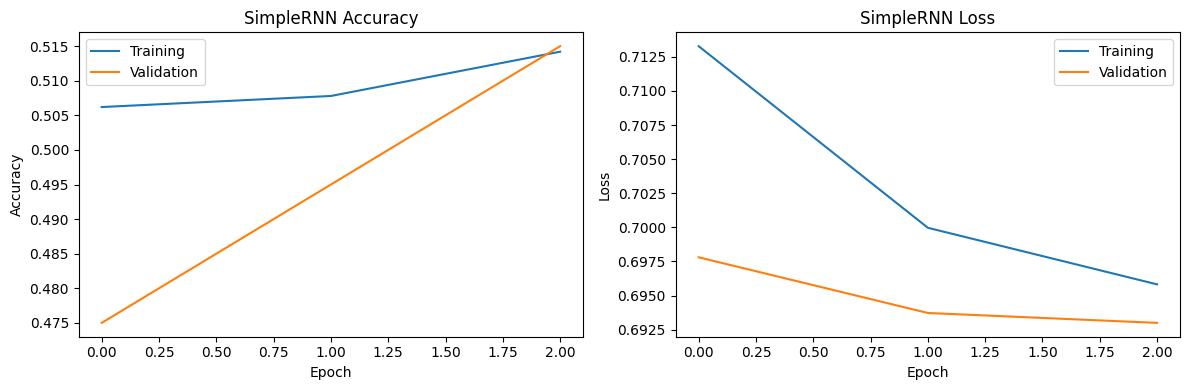


✅ SimpleRNN Complete!
  • Successfully processes sequences
  • Maintains hidden state across time steps
  • Can capture some temporal dependencies
  • Ready to compare with advanced architectures


In [30]:
print("Building a SimpleRNN Model:")
print("=" * 40)

# Create a SimpleRNN model
vocab_size = 10000
embedding_dim = 128
rnn_units = 64

print("🔧 Model Architecture:")
print("  1. Embedding Layer: Convert word IDs to dense vectors")
print("  2. SimpleRNN Layer: Process sequences with memory")
print("  3. Dense Layer: Final classification")

simple_rnn_model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.SimpleRNN(rnn_units, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
simple_rnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n📋 Model Summary:")
simple_rnn_model.summary()

# Build the model before plotting (required for visualization)
simple_rnn_model.build(input_shape=(None, max_length))

print("\n🎯 Key RNN Concepts:")
print("  • Hidden State: RNN memory that passes between time steps")
print("  • Recurrent Weights: Weights for the hidden state")
print("  • Input Weights: Weights for current input")
print("  • Dropout: Prevents overfitting during training")

# Train the model
print("\n🚀 Training SimpleRNN...")
print("This may take a few minutes...")

# Use a subset for faster training in the lab
subset_size = 5000
X_train_subset = X_train_padded[:subset_size]
y_train_subset = y_train_imdb[:subset_size]
X_val_subset = X_test_padded[:1000]
y_val_subset = y_test_imdb[:1000]

history_simple = simple_rnn_model.fit(
    X_train_subset, y_train_subset,
    batch_size=128,
    epochs=3,  # Few epochs for lab demonstration
    validation_data=(X_val_subset, y_val_subset),
    verbose=1
)

# Evaluate the model
print("\n📊 SimpleRNN Results:")
test_loss, test_accuracy = simple_rnn_model.evaluate(X_test_padded[:1000], y_test_imdb[:1000], verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_simple.history['accuracy'], label='Training')
plt.plot(history_simple.history['val_accuracy'], label='Validation')
plt.title('SimpleRNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_simple.history['loss'], label='Training')
plt.plot(history_simple.history['val_loss'], label='Validation')
plt.title('SimpleRNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("\n✅ SimpleRNN Complete!")
print("  • Successfully processes sequences")
print("  • Maintains hidden state across time steps")
print("  • Can capture some temporal dependencies")
print("  • Ready to compare with advanced architectures")

## Step 4: Advanced RNN Architectures

Now let's compare SimpleRNN with more sophisticated architectures:

Advanced RNN Architectures Comparison:
🧠 RNN Evolution:
  1. SimpleRNN: Basic memory, suffers from vanishing gradients
  2. LSTM: Long Short-Term Memory, solves vanishing gradient problem
  3. GRU: Gated Recurrent Unit, simpler than LSTM but effective

🚀 Building LSTM Model...
🚀 Building GRU Model...

📊 Model Comparison:
------------------------------
Parameter Count:
  SimpleRNN: 1,292,417 parameters
  LSTM:      1,329,473 parameters
  GRU:       1,317,313 parameters

🏃 Training LSTM...
Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.5064 - loss: 0.6937 - val_accuracy: 0.4860 - val_loss: 0.6942
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.5672 - loss: 0.6852 - val_accuracy: 0.5450 - val_loss: 0.6924
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.6138 - loss: 0.6615 - val_accuracy: 0.5590 - val_loss: 0.6803

🏃 Training GRU...
Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.5012 - loss: 0.6941 - val_accuracy: 0.482

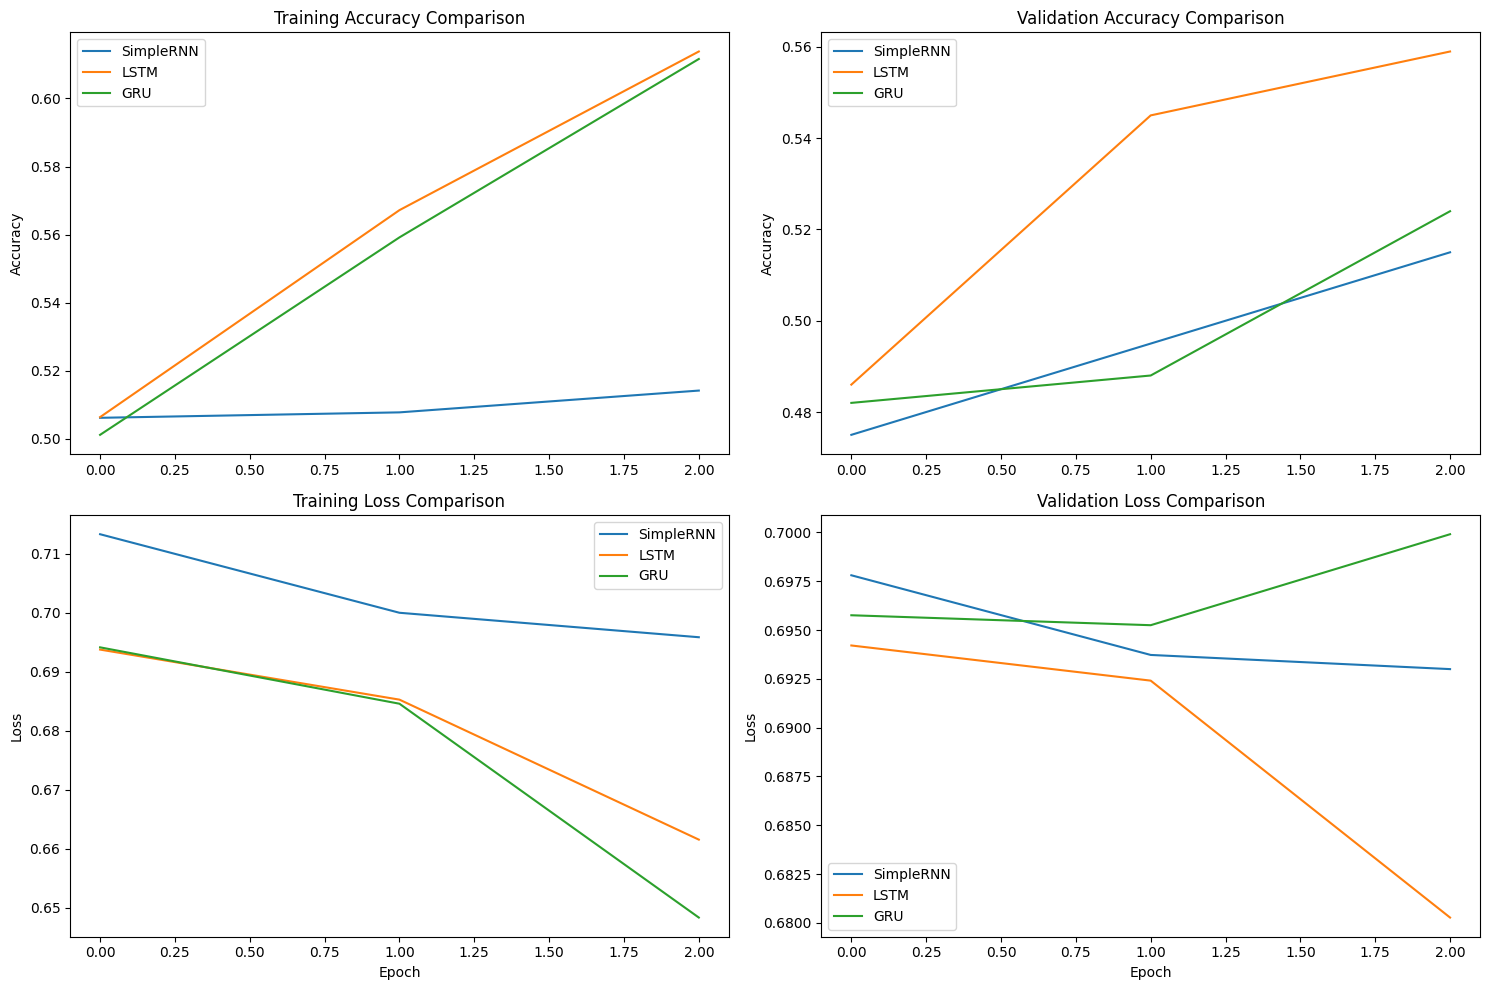

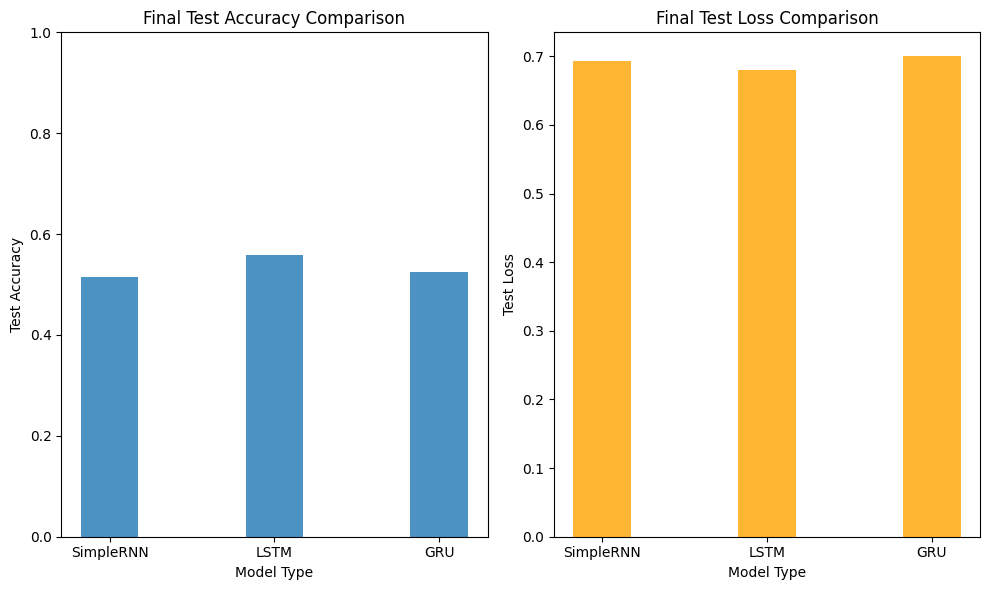


🎯 Key Insights:
  • LSTM: Best for long sequences, handles vanishing gradients
  • GRU: Simpler than LSTM, often similar performance
  • SimpleRNN: Fastest but limited by vanishing gradients
  • Memory mechanisms make LSTM/GRU more powerful

🏆 Architecture Recommendations:
  • Short sequences (<50 steps): SimpleRNN may suffice
  • Long sequences (>100 steps): Use LSTM or GRU
  • Limited compute: Try GRU first
  • Complex patterns: LSTM with more units

✅ RNN Architecture Comparison Complete!
You now understand the tradeoffs between different RNN types.


In [31]:
print("Advanced RNN Architectures Comparison:")
print("=" * 50)

print("🧠 RNN Evolution:")
print("  1. SimpleRNN: Basic memory, suffers from vanishing gradients")
print("  2. LSTM: Long Short-Term Memory, solves vanishing gradient problem")
print("  3. GRU: Gated Recurrent Unit, simpler than LSTM but effective")

# Build LSTM model
print("\n🚀 Building LSTM Model...")
lstm_model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.LSTM(rnn_units, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build the LSTM model to enable parameter counting
lstm_model.build(input_shape=(None, max_length))

# Build GRU model
print("🚀 Building GRU Model...")
gru_model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.GRU(rnn_units, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(1, activation='sigmoid')
])

gru_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build the GRU model to enable parameter counting
gru_model.build(input_shape=(None, max_length))

print("\n📊 Model Comparison:")
print("-" * 30)

# Compare model parameters
print("Parameter Count:")
simple_params = simple_rnn_model.count_params()
lstm_params = lstm_model.count_params()
gru_params = gru_model.count_params()

print(f"  SimpleRNN: {simple_params:,} parameters")
print(f"  LSTM:      {lstm_params:,} parameters")
print(f"  GRU:       {gru_params:,} parameters")

# Train LSTM
print("\n🏃 Training LSTM...")
history_lstm = lstm_model.fit(
    X_train_subset, y_train_subset,
    batch_size=128,
    epochs=3,
    validation_data=(X_val_subset, y_val_subset),
    verbose=1
)

# Train GRU
print("\n🏃 Training GRU...")
history_gru = gru_model.fit(
    X_train_subset, y_train_subset,
    batch_size=128,
    epochs=3,
    validation_data=(X_val_subset, y_val_subset),
    verbose=1
)

# Evaluate all models
print("\n📊 Performance Comparison:")
print("=" * 40)

models = {
    'SimpleRNN': (simple_rnn_model, history_simple),
    'LSTM': (lstm_model, history_lstm),
    'GRU': (gru_model, history_gru)
}

results = {}
for name, (model, history) in models.items():
    test_loss, test_accuracy = model.evaluate(X_test_padded[:1000], y_test_imdb[:1000], verbose=0)
    results[name] = {'accuracy': test_accuracy, 'loss': test_loss, 'history': history}
    print(f"{name:>10}: {test_accuracy:.4f} accuracy, {test_loss:.4f} loss")

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training accuracy
axes[0, 0].set_title('Training Accuracy Comparison')
for name, data in results.items():
    axes[0, 0].plot(data['history'].history['accuracy'], label=name)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Validation accuracy
axes[0, 1].set_title('Validation Accuracy Comparison')
for name, data in results.items():
    axes[0, 1].plot(data['history'].history['val_accuracy'], label=name)
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Training loss
axes[1, 0].set_title('Training Loss Comparison')
for name, data in results.items():
    axes[1, 0].plot(data['history'].history['loss'], label=name)
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()

# Validation loss
axes[1, 1].set_title('Validation Loss Comparison')
for name, data in results.items():
    axes[1, 1].plot(data['history'].history['val_loss'], label=name)
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Performance bar chart
plt.figure(figsize=(10, 6))
names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in names]
losses = [results[name]['loss'] for name in names]

x = np.arange(len(names))
width = 0.35

plt.subplot(1, 2, 1)
plt.bar(x, accuracies, width, alpha=0.8)
plt.xlabel('Model Type')
plt.ylabel('Test Accuracy')
plt.title('Final Test Accuracy Comparison')
plt.xticks(x, names)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(x, losses, width, alpha=0.8, color='orange')
plt.xlabel('Model Type')
plt.ylabel('Test Loss')
plt.title('Final Test Loss Comparison')
plt.xticks(x, names)

plt.tight_layout()
plt.show()

print("\n🎯 Key Insights:")
print("  • LSTM: Best for long sequences, handles vanishing gradients")
print("  • GRU: Simpler than LSTM, often similar performance")
print("  • SimpleRNN: Fastest but limited by vanishing gradients")
print("  • Memory mechanisms make LSTM/GRU more powerful")

print("\n🏆 Architecture Recommendations:")
print("  • Short sequences (<50 steps): SimpleRNN may suffice")
print("  • Long sequences (>100 steps): Use LSTM or GRU")
print("  • Limited compute: Try GRU first")
print("  • Complex patterns: LSTM with more units")

print("\n✅ RNN Architecture Comparison Complete!")
print("You now understand the tradeoffs between different RNN types.")